100%|██████████| 170498071/170498071 [00:06<00:00, 27652602.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data loaded successfully...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[epoch 1, iter   200] loss: 1.963
[epoch 1, iter   400] loss: 1.663
[epoch 1, iter   600] loss: 1.565


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch 1: train_acc 48.080, test_acc 48.040
[epoch 2, iter   200] loss: 1.449
[epoch 2, iter   400] loss: 1.401
[epoch 2, iter   600] loss: 1.371
epoch 2: train_acc 51.976, test_acc 50.630
[epoch 3, iter   200] loss: 1.334
[epoch 3, iter   400] loss: 1.288
[epoch 3, iter   600] loss: 1.264
epoch 3: train_acc 56.928, test_acc 55.410
[epoch 4, iter   200] loss: 1.246
[epoch 4, iter   400] loss: 1.211
[epoch 4, iter   600] loss: 1.201
epoch 4: train_acc 58.390, test_acc 56.290
[epoch 5, iter   200] loss: 1.163
[epoch 5, iter   400] loss: 1.154
[epoch 5, iter   600] loss: 1.138
epoch 5: train_acc 60.590, test_acc 57.860
[epoch 6, iter   200] loss: 1.138
[epoch 6, iter   400] loss: 1.112
[epoch 6, iter   600] loss: 1.095
epoch 6: train_acc 61.104, test_acc 58.200
[epoch 7, iter   200] loss: 1.061
[epoch 7, iter   400] loss: 1.073
[epoch 7, iter   600] loss: 1.065
epoch 7: train_acc 63.996, test_acc 59.620
[epoch 8, iter   200] loss: 1.032
[epoch 8, iter   400] loss: 1.041
[epoch 8, iter   60

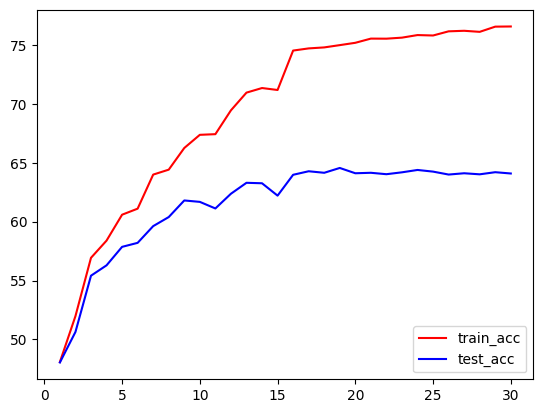

In [1]:
# CIFAR-10 Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import torchvision as tv
import torchvision.transforms as transforms


import matplotlib.pyplot as plt
import numpy as np
import math
import os


from torch.optim.lr_scheduler import StepLR


train_batch_size = 64
test_batch_size = 1000


class Net(nn.Module):
   def __init__(self):
       super(Net, self).__init__()
       self.conv1 = nn.Conv2d(3, 6, 5)  # Adjust input channels to 3 for CIFAR-10
       self.conv2 = nn.Conv2d(6, 16, 5)
       self.fc1 = nn.Linear(16 * 5 * 5, 120)
       self.fc2 = nn.Linear(120, 84)
       self.fc3 = nn.Linear(84, 10)  # Adjust output to 10 for CIFAR-10


   def forward(self, x):
       x = F.max_pool2d(F.relu(self.conv1(x)), 2)
       x = F.max_pool2d(F.relu(self.conv2(x)), 2)
       x = x.view(-1, self.num_flat_features(x))
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = self.fc3(x)
       return x


   def num_flat_features(self, x):
       size = x.size()[1:]
       num_features = 1
       for s in size:
           num_features *= s
       return num_features


def load_data():
   transform = transforms.Compose([
       transforms.Resize((32, 32)),  # Resize images to 32x32 for CIFAR-10
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust normalization for CIFAR-10
   ])
   train_set = tv.datasets.CIFAR10(
       root='./data',
       train=True,
       download=True,
       transform=transform
   )
   train_loader = torch.utils.data.DataLoader(
       train_set,
       batch_size=train_batch_size,
       shuffle=True,
       num_workers=2
   )
   test_set = tv.datasets.CIFAR10(
       root='./data',
       train=False,
       download=True,
       transform=transform
   )
   test_loader = torch.utils.data.DataLoader(
       test_set,
       batch_size=test_batch_size,
       shuffle=False,
       num_workers=2
   )
   print("Data loaded successfully...")
   return train_loader, test_loader


def accuracy(model, data_loader):
   with torch.no_grad():
       correct = 0
       total = 0
       for data in data_loader:
           images, labels = data
           outputs = model(images)
           _, predicted = torch.max(outputs.data, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()


   return (100 * correct / total)


def train(train_loader, test_loader, model, criterion, optimizer, scheduler, max_epoch):
   train_acc = []
   test_acc = []
   for epoch in range(max_epoch):
       model.train()
       running_loss = 0
       for i, data in enumerate(train_loader, 0):
           inputs, labels = data
           optimizer.zero_grad()
           outputs = model(inputs)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()


           running_loss += loss.item()
           if i % 200 == 199:
               print("[epoch %d, iter %5d] loss: %.3f" % (epoch+1, i+1, running_loss / 200))
               running_loss = 0.0




       # Update learning rate
       scheduler.step()


       train_acc_epoch = accuracy(model, train_loader)
       test_acc_epoch = accuracy(model, test_loader)
       train_acc.append(train_acc_epoch)
       test_acc.append(test_acc_epoch)
       print("epoch %d: train_acc %.3f, test_acc %.3f" % (epoch+1, train_acc_epoch, test_acc_epoch))


   return train_acc, test_acc


def display(train_acc, test_acc):
   fig, ax = plt.subplots()
   ax.plot(range(1, len(train_acc) + 1), train_acc, color='r', label='train_acc')
   ax.plot(range(1, len(test_acc) + 1), test_acc, color='b', label='test_acc')
   ax.legend(loc='lower right')
   plt.show()


if __name__ == '__main__':
   # Input CIFAR-10
   train_loader, test_loader = load_data()
   # New model
   net = Net()


   # Training
   learning_rate = 0.0008
   max_epoch = 30
   criterion = nn.CrossEntropyLoss()
   #optimizer = optimizer = optim.Adam(net.parameters(), lr=learning_rate)
   optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))  # You can adjust the betas parameter for momentum


 #Learning rate scheduler
   step_size = 15  # Step size for learning rate decay
   gamma = 0.1     # Multiplicative factor for learning rate decay
   scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


   train_acc, test_acc = train(train_loader, test_loader, net, criterion, optimizer, scheduler, max_epoch)


   display(train_acc, test_acc)
